*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
#!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-04-08 20:43:00--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.7’

insurance.csv.7     100%[===================>]  49.09K  --.-KB/s    in 0s      

2022-04-08 20:43:00 (105 MB/s) - ‘insurance.csv.7’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


Firstly, I investigate the database's predictive variables distribution grouped by gender to find outliers.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


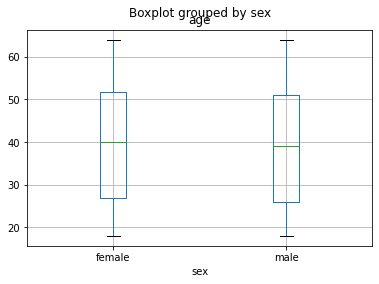

In [3]:
dataset.boxplot(column = 'age', by = 'sex')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


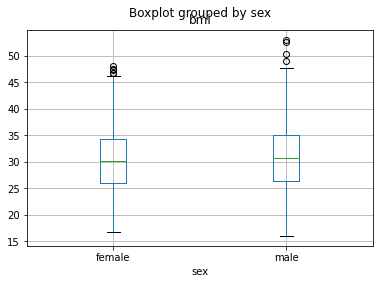

In [4]:
dataset.boxplot(column = 'bmi', by = 'sex')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


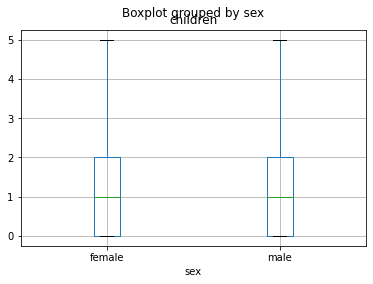

In [5]:
dataset.boxplot(column = 'children', by = 'sex')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


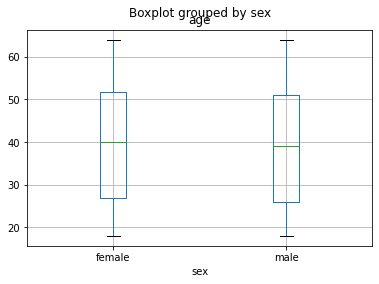

In [6]:
dataset.boxplot(column = 'age', by = 'sex')

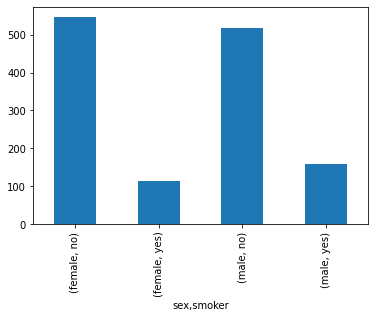

In [7]:
dataset.groupby(['sex'])['smoker'].value_counts().plot(kind = 'bar', sort_columns = True)

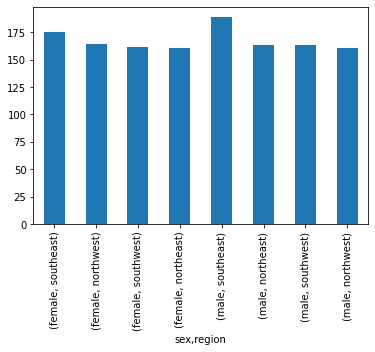

In [8]:
dataset.groupby(['sex'])['region'].value_counts().plot(kind = 'bar')

Only the `bmi` variable have outliers, as so, they are dropped from the database using the `1.5 * IQR` criteria.

In [9]:
bmi_iqr = dataset['bmi'].quantile(0.75) - dataset['bmi'].quantile(0.25)

dataset = dataset[dataset['bmi'] <= dataset['bmi'].quantile(0.75) + 1.5 * bmi_iqr].reset_index()

Then, all numeric variables are normalized using the Z-score approach...

In [10]:
quantitatives = ['age', 'bmi', 'children']
quant_var = (dataset[quantitatives] - dataset[quantitatives].mean()) / dataset[quantitatives].std()

... and categorical variables (`sex`, `smoker`, and `region`) are converted to logical. In `region` case, it is converted using the one-hot approach.

In [11]:
# Cast st to one-hot
region_var = pd.get_dummies(dataset['region'])

# Cast str to logical
sex_var = pd.get_dummies(dataset['sex'], drop_first = True)
smoker_var = pd.get_dummies(dataset['smoker'], drop_first = True)

Finally, the processed variables are written to a new dataset...

In [12]:
clean_dataset = pd.concat(
    [
        quant_var,
        region_var,
        sex_var,
        smoker_var,
        dataset['expenses']
    ],
    axis = 1
)\
    .rename(columns = {'male': 'gender', 'yes': 'smoker'})\
    .sample(frac = 1.)

clean_dataset

,age,bmi,children,northeast,northwest,southeast,southwest,gender,smoker,expenses
927,0.412596,0.804128,-0.907598,0,0,0,1,0,0,7348.14
73,1.338006,0.246711,-0.079734,0,0,1,0,1,0,11946.63
785,1.622747,-0.108009,-0.907598,0,0,1,0,0,0,13457.96
890,0.270226,-1.780260,0.748130,1,0,0,0,0,1,19798.05
957,0.483782,-0.969471,1.575994,1,0,0,0,1,0,9500.57
...,...,...,...,...,...,...,...,...,...,...
842,0.839709,0.618323,-0.079734,0,0,0,1,0,0,9872.70
40,-1.082296,-0.665426,-0.907598,1,0,0,0,0,0,3046.06
819,0.341411,-0.124900,0.748130,0,0,1,0,0,0,8219.20
633,-0.299257,1.277088,0.748130,1,0,0,0,0,0,24915.05


... and split into training and testing datasets.

In [13]:
train_frac = int(0.8 * clean_dataset.shape[0])

train_dataset = clean_dataset.iloc[:train_frac].reset_index(drop = True)
train_labels = train_dataset.pop('expenses')

test_dataset = clean_dataset.iloc[train_frac:].reset_index(drop = True)
test_labels = test_dataset.pop('expenses')

I choose to model the `expenses` using two deep, dense neural layers with 8 units each. As there is no sense in negative `expenses` values, they use the ReLU activation function.

In [14]:
model = keras.models.Sequential()

model.add(layers.Dense(
    8,
    batch_input_shape = (None, 9),
    activation = 'relu'))
model.add(layers.Dense(
    8,
    activation = 'relu'))
model.add(layers.Dense(
    1,
    activation = 'relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [15]:
class CallbackEarlyStopMAE(keras.callbacks.Callback):
    """
    Callback to stop the model training when the target MAE is achieved
    
    Modified from TensorFlow Documentation's example:
    https://www.tensorflow.org/guide/keras/custom_callback#early_stopping_at_minimum_loss
    """
    def __init__(self, patience = 3, target_mae = 3500.):
        super(CallbackEarlyStopMAE, self).__init__()
        self.patience = patience
        self.target_mae = target_mae
        self.best_weights = None
    
    def on_train_begin(self, logs = None):
        self.wait = 0
        self.stopped_epoch = 0
        self.best_mae = np.Inf

    def on_epoch_end(self, epoch, logs = None):
        current_mae = logs.get('mae')

        if np.greater(current_mae, self.target_mae):
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1

            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
    
    def on_train_end(self, logs = None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [16]:
epochs = 100
LR = 0.01

model.compile(
    optimizer = keras.optimizers.RMSprop(
        learning_rate = LR,
        epsilon = 1e-5,
        centered = True
    ),
    loss = 'mean_absolute_percentage_error',
    metrics = 'mae'
)

history = model.fit(
    train_dataset,
    train_labels,
    epochs = epochs,
    callbacks = [CallbackEarlyStopMAE()]
)

Epoch 1/100
34/34 [==============================] - 3s 8ms/step - loss: 99.6420 - mae: 13306.4023
Epoch 2/100
34/34 [==============================] - 0s 11ms/step - loss: 92.5430 - mae: 12929.8887
Epoch 3/100
34/34 [==============================] - 0s 10ms/step - loss: 77.3396 - mae: 11861.5381
Epoch 4/100
34/34 [==============================] - 0s 9ms/step - loss: 72.0909 - mae: 11194.3486
Epoch 5/100
34/34 [==============================] - 0s 10ms/step - loss: 66.9901 - mae: 10483.3379
Epoch 6/100
34/34 [==============================] - 0s 10ms/step - loss: 60.1526 - mae: 9666.3828
Epoch 7/100
34/34 [==============================] - 0s 8ms/step - loss: 50.6807 - mae: 8450.9863
Epoch 8/100
34/34 [==============================] - 0s 9ms/step - loss: 40.2278 - mae: 7042.3071
Epoch 9/100
34/34 [==============================] - 0s 9ms/step - loss: 31.1174 - mae: 5840.6284
Epoch 10/100
34/34 [==============================] - 0s 9ms/step - loss: 22.2034 - mae: 4821.4165
Epoch 11/1

9/9 - 0s - loss: 11.5448 - mae: 3340.9387 - 430ms/epoch - 48ms/step
Testing set Mean Abs Error: 3340.94 expenses
You passed the challenge. Great job!


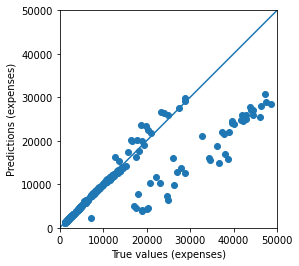

In [17]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
